# Water Temperature Prediction Based on CalCOFI Data

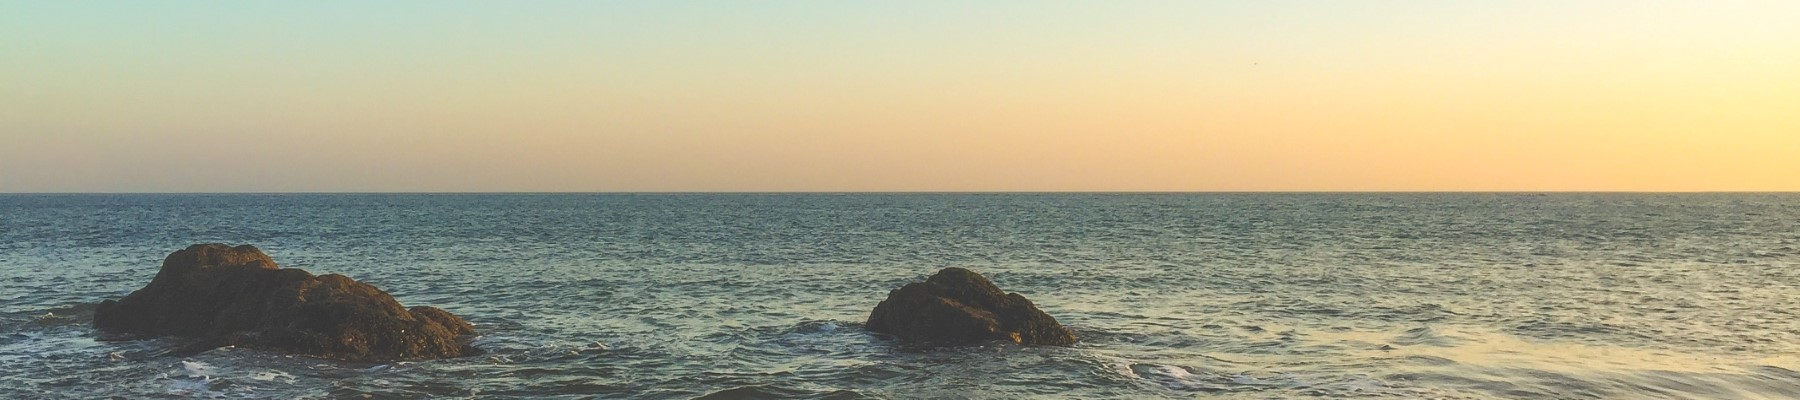

## Table of Contents

- [Introduction](#introduction)
- [Data Exploration](#data-exploration)
- [Data Cleaning](#data-cleaning)
- [Data Splitting](#data-splitting)
- [Feature Extraction](#feature-extraction)
- [Data Visualization](#data-visualization)
- [Outliers Detection](#outliers-detection)
- [Feature Selection](#feature-selection)
- [Feature Preprocessing and Feature Engineering](#feature-preprocessing)
- [Choosing a Model](#model-choosing)
- [Fitting and Evaluating the Model](#model-evaluating)
- [Conclusion](#conclusion)

<a id="introduction"></a>
## Introduction

The CalCOFI data set is the longest (from 1949) and the most complete time series of oceanographic data in the world. This data is primarily used to study the effects of climate change on marine ecosystems.

The samples of ocean water are collected quarterly during expeditions off southern and central California, and then chemical analyses of the samples are performed. Bottles with water are collected from 24 sampling depths (down to 500 m) and at numerous stations. The measurements include: temperature, salinity, oxygen, phosphate, silicate, nitrate and nitrite, chlorophyll, C14 primary productivity, etc.

The dataset consists of two parts: the `cast` table and the `bottle` table. The first one contains metadata on all the casts conducted, and the second one contains the results of the measurements. For the purpose of predicting water temperature based on other oceanographic measurements we will leverage the data within the `bottle` table.

For prediction we will leverage linear regression analysis and compare three different models: vanilla linear regression, polynomial regression, and regression splines.  

The dataset can be downloaded from Kaggle (https://www.kaggle.com/datasets/sohier/calcofi?select=bottle.csv) or directly from CalCOFI website (https://calcofi.org/data/oceanographic-data/bottle-database/).

<a id="data-exploration"></a>
## Data Exploration

Let's start with some useful imports.

In [99]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, SplineTransformer, FunctionTransformer
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

In [100]:
pd.set_option('display.max_rows', None) # Set display options to see all the rows and columns of the dataset.
pd.set_option('display.max_columns', None)

When reading the dataset, we will exclude columns that are not informative, present informational leakage (measurements derived from other measurements), columns that represent the quality and precision of other measurements, and those that represent indicators connected with sea life.

In [101]:
dataset_filepath = 'bottle.csv'
columns_to_load = ['Depth_ID', 'Depthm', 'T_degC', 'Salnty', 'O2ml_L', 'PO4uM', 'SiO3uM', 'NO2uM', 'NO3uM',
                   'NH3uM', 'Sta_ID']

original_data = pd.read_csv(dataset_filepath, usecols=columns_to_load, low_memory=False) # Low memory is set to False as we have columns with mixed datatypes.

Let's take a brief look into the dataset.

In [102]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864863 entries, 0 to 864862
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Sta_ID    864863 non-null  object 
 1   Depth_ID  864863 non-null  object 
 2   Depthm    864863 non-null  int64  
 3   T_degC    853900 non-null  float64
 4   Salnty    817509 non-null  float64
 5   O2ml_L    696201 non-null  float64
 6   PO4uM     413317 non-null  float64
 7   SiO3uM    354091 non-null  float64
 8   NO2uM     337576 non-null  float64
 9   NO3uM     337403 non-null  float64
 10  NH3uM     64962 non-null   float64
dtypes: float64(8), int64(1), object(2)
memory usage: 72.6+ MB


The size of the dataset is more than 860 thousands of samples. We can see all 10 relevant kinds of measurements, their dtypes, and the number of non-null entires. 

We will take temperature in Celcius (T_degC) as our target column and the rest will serve as features.

Let's see what these columns mean:
- *Depth_ID*: [Century]-[Year][Month][ShipCode]-[CastType][Julian Day]-[CastTime]-[Line][Sta][Depth][Bottle]-[Rec_Ind]
- *Sta_ID*: [Line] [Station]
- *Depthm*: bottle depth in meters
- *T_degC*: water temperature in degrees Celsius
- *Salnty*: salinity (according to Practical Salinity Scale 1978)
- *O2ml_L*:	milliliters oxygen per liter of seawater
- *PO4uM*:	micromoles of Phosphate per liter of seawater
- *SiO3uM*:	micromoles of Silicate per liter of seawater
- *NO2uM*:	micromoles of Nitrite per liter of seawater
- *NO3uM*:	micromoles of Nitrate per liter of seawater
- *NH3uM*:	micromoles of Ammonia per liter of seawater

Now let's see some general statistics of the numerical columns. We will not jump to any conclusions at this point to prevent informational leakage as we have not yet divided the data into training and test sets.

In [103]:
original_data.describe()

,Depthm,T_degC,Salnty,O2ml_L,PO4uM,SiO3uM,NO2uM,NO3uM,NH3uM
count,864863.000000,853900.000000,817509.000000,696201.000000,413317.000000,354091.000000,337576.000000,337403.000000,64962.000000
mean,226.831951,10.799677,33.840350,3.392468,1.564747,26.606587,0.042316,17.302247,0.084877
std,316.050259,4.243825,0.461843,2.073256,1.035966,27.648190,0.104196,14.581958,0.273061
min,0.000000,1.440000,28.431000,-0.010000,0.000000,0.000000,0.000000,-0.400000,0.000000
25%,46.000000,7.680000,33.488000,1.360000,0.470000,3.110000,0.000000,0.600000,0.000000
50%,125.000000,10.060000,33.863000,3.440000,1.570000,18.000000,0.010000,18.100000,0.000000
75%,300.000000,13.880000,34.196900,5.500000,2.480000,41.540000,0.030000,30.000000,0.060000
max,5351.000000,31.140000,37.034000,11.130000,5.210000,196.000000,8.190000,95.000000,15.630000


<a id="data-cleaning"></a>
## Data Cleaning

Before we divide the dataset into training and testing sets, we will get rid of columns with too many null values. 

Let's copy the dataset first in order to keep the original one intact.

In [104]:
df = original_data.copy()

Now we are going to examine the quantity of null values.

In [105]:
df.isnull().sum()

Sta_ID           0
Depth_ID         0
Depthm           0
T_degC       10963
Salnty       47354
O2ml_L      168662
PO4uM       451546
SiO3uM      510772
NO2uM       527287
NO3uM       527460
NH3uM       799901
dtype: int64

Since some of the columns contain a significant number of null values, we will drop those that have more than 25% of their entries marked as null.

In [106]:
threshold = round(df.shape[0] * 0.25)
cols_to_drop = [col for col in df.columns if df[col].isnull().sum() > threshold]
df.drop(cols_to_drop, inplace=True, axis=1)

Now, we will drop the rows containing null values in our target column - T_degC. 

In [107]:
df.dropna(subset=['T_degC'], inplace=True, axis=0)

Considering the large size of the dataset (more than 860 thousand samples), we will remove the rows containing null values in the remaining columns, as we still have a substantial number of samples for modelling even after their removal.

In [108]:
df.dropna(inplace=True, axis=0)

<a id="data-splitting"></a>
## Data Splitting

As the data does not have a predefined train/test split, we will do it ourselves.

In [109]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('T_degC', axis=1), df.T_degC, test_size=0.3, random_state=1)

Let's peep into our training and test sets.

In [110]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 463042 entries, 640561 to 207094
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Sta_ID    463042 non-null  object 
 1   Depth_ID  463042 non-null  object 
 2   Depthm    463042 non-null  int64  
 3   Salnty    463042 non-null  float64
 4   O2ml_L    463042 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 21.2+ MB


In [111]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198447 entries, 768271 to 591667
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Sta_ID    198447 non-null  object 
 1   Depth_ID  198447 non-null  object 
 2   Depthm    198447 non-null  int64  
 3   Salnty    198447 non-null  float64
 4   O2ml_L    198447 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 9.1+ MB


We are left with 463 thousand samples for training the model and 198 thousand samples for testing, which is more than sufficient for our purpose.

The remaining features are: Depth in meters, Salinity, O2 concentration, and two ID columns - Depth_ID and Sta_ID, from which we will derive some useful features later.

Now we can safely examine the numerical statistics of our training set.

In [112]:
x_train.describe()

,Depthm,Salnty,O2ml_L
count,463042.000000,463042.000000,463042.000000
mean,219.483414,33.832581,3.416018
std,310.587246,0.460339,2.068245
min,0.000000,29.402000,-0.010000
25%,49.000000,33.479525,1.410000
50%,125.000000,33.853000,3.470000
75%,300.000000,34.184000,5.516000
max,5351.000000,37.034000,11.130000


We already can see that the distribution of feature values across quantiles is not even (especially when it comes to depth). Moreover, the features are on a pretty different scale, so as a preprocessing step we will rescale them.

<a id="feature-extraction"></a>
## Feature Extraction

We have two ID columns that contain pretty useful information - Sta_ID and Depth_ID. So we will use them to derive new temporal and spatial features.

In [113]:
x_train['Month'] = x_train['Depth_ID'].str.slice(5,7) 
x_train['Season'] = np.nan 
x_train.loc[x_train.Month.isin(['01', '02', '12']), 'Season'] = '1' # Winter
x_train.loc[x_train.Month.isin(['03', '04', '05']), 'Season'] = '2' # Spring
x_train.loc[x_train.Month.isin(['06', '07', '08']), 'Season'] = '3' # Summer
x_train.loc[x_train.Month.isin(['09', '10', '11']), 'Season'] = '4' # Autumn
x_train['Year'] = x_train['Depth_ID'].str.slice(0,2) + x_train['Depth_ID'].str.slice(3,5) 

x_train['Year'] = x_train['Year'].astype('category') 
x_train['Season'] = x_train['Season'].astype('category')
x_train['Month'] = x_train['Month'].astype('category')

x_train.drop(['Depth_ID'], axis=1, inplace=True) 

x_train[['Line', 'Station']] = x_train['Sta_ID'].str.split(expand=True) 
x_train['Line'] = x_train['Line'].astype(float) 
x_train['Station'] = x_train['Station'].astype(float) 

x_train.drop(['Sta_ID'], axis=1, inplace=True) 

To convert station and line IDs into latitudes and longitudes, we will utilize the helper function provided in this paper:
http://calcofi.com/publications/calcofireports/v54/Vol_54_Weber_97-106.pdf

In [114]:
def tomercator(latitude):
    latitude = np.array(latitude)
    y = np.rad2deg(
    np.log(np.tan(np.deg2rad(45 + latitude / 2))) - 0.00676866 * np.sin(np.deg2rad(latitude)))
    return(y)


def stationtolatlon(x, y=None):
    """
    x is line, y is station, or x is a matrix
    x and y are numbers, lists, tuples,
    or numpy arrays,
    """
    if y == None:
        line = x[:, 0]
        station = x[:, 1]
    else:
        line = x
        station = y
    line = np.array(line, dtype='float')
    station = np.array(station, dtype='float')
    # need reshape b/c single numbers could
    # be wrapped in arrays
    if len(line.shape) == 0:
        line = line.reshape(1)
    if len(station.shape) == 0:
        station = station.reshape(1)
    
    refLatitude = (34.15 - 0.2 * (line - 80) * np.cos(np.deg2rad(30)))
    latitude = (refLatitude - (station - 60) * np.sin(np.deg2rad(30)) / 15)
    
    L1 = ((tomercator(latitude) - tomercator(34.15)) * np.tan(np.deg2rad(30)))
    L2 = (((tomercator(refLatitude) - tomercator(latitude)) / (np.cos(np.deg2rad(30)) * np.sin(np.deg2rad(30)))))
    longitude = -1 * (L1 + L2 + 121.15)
    ans = np.vstack((longitude, latitude)).T
    
    if len(line) == 1:
        ans = ans[0]
        
    return(ans)

In [115]:
x_train[['Longitude', 'Latitude']] = x_train.apply(lambda row: pd.Series(stationtolatlon(row['Line'], row['Station'])), axis=1)

x_train.drop(['Line', 'Station'], axis=1, inplace=True)

<a id="data-visualization"></a>
## Data Visualization

To get a better grasp of the data and gather valuable insights, let's dive into data visualization.

In [116]:
merged_df = x_train.join(y_train) # Merge the target and the features back together for the purpose of visualization.

### Target vs Features 

First let's look at the relationships between the target and the features.

We will start with temperature and depth.

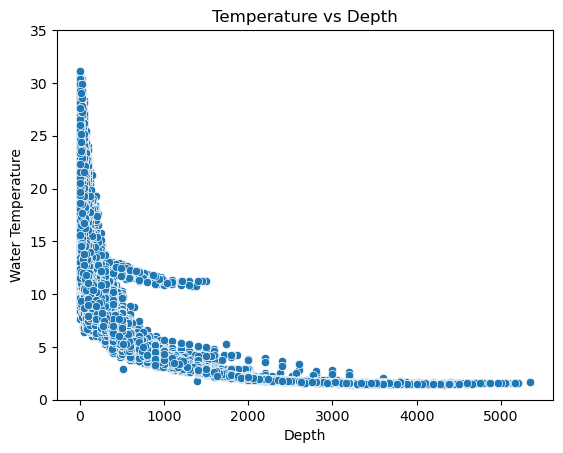

In [117]:
fig, ax = plt.subplots()
sns.scatterplot(data=merged_df, x='Depthm', y='T_degC', ax=ax)
ax.set_ylim(0, 35)
plt.xlabel('Depth')
plt.ylabel('Water Temperature')
plt.title('Temperature vs Depth')
plt.show()

We can observe a distinct trend of decreasing temperature levels with increasing depth, which is quite logical.

The plot also displays two tails that are of interest. It is possible that the tail with higher temperature levels corresponds to a subset of samples taken from stations located further to the south. Let's investigate whether the geographical coordinates at which the samples were taken influence the temperature.

To do this, we will create plots illustrating the relationship between longitude and temperature, as well as latitude and temperature.

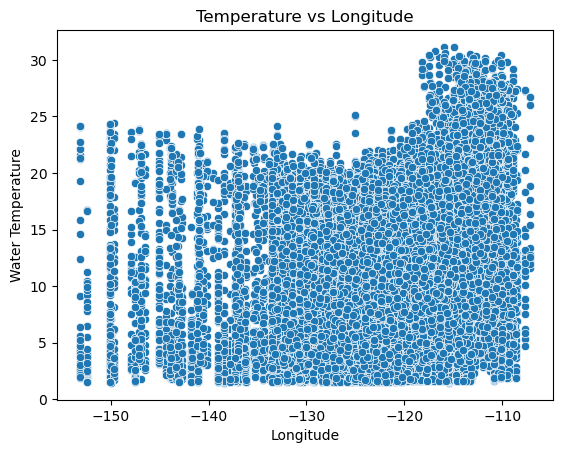

In [118]:
sns.scatterplot(data=merged_df, x='Longitude', y='T_degC')
plt.title('Temperature vs Longitude')
plt.xlabel('Longitude')
plt.ylabel('Water Temperature')
plt.show()

We can observe that the temperature exhibits a wider range of values between -118 and -110 degrees of longitude.

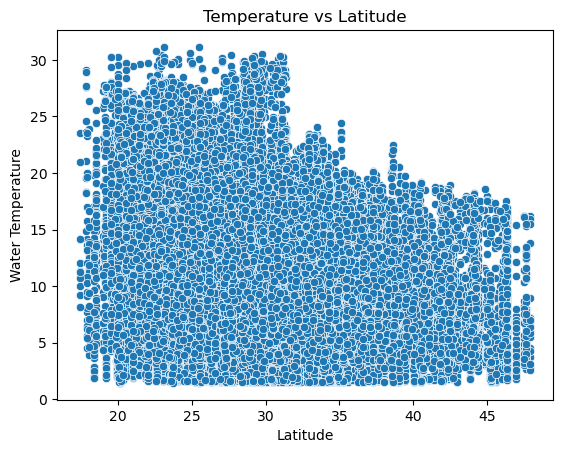

In [119]:
sns.scatterplot(data=merged_df, x='Latitude', y='T_degC')
plt.title('Temperature vs Latitude')
plt.xlabel('Latitude')
plt.ylabel('Water Temperature')
plt.show()

The temperature variance for latitude is higher within the range of approximately 18 to 32 degrees.

Let's see if we can explain the second tail in the temperature vs depth plot with these foundings.

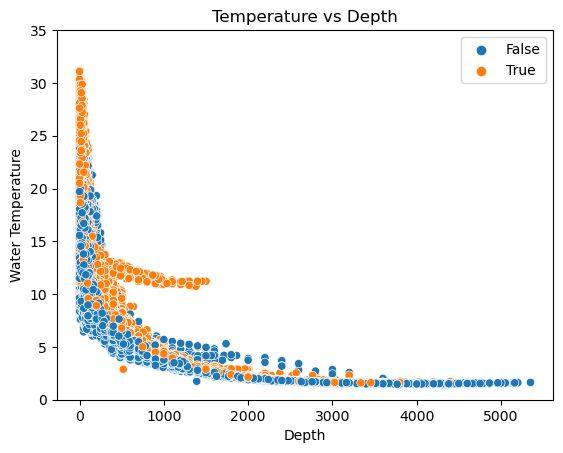

In [120]:
fig, ax = plt.subplots()
sns.scatterplot(data=merged_df, x='Depthm', y='T_degC', ax=ax, hue=(merged_df.Latitude<32)&(merged_df.Longitude>-118))
ax.set_ylim(0, 35)
plt.xlabel('Depth')
plt.ylabel('Water Temperature')
plt.title('Temperature vs Depth')
plt.show()

As we can see, latitude and longitude can, at least partially, account for the variance in temperature levels for depths shallower than 2000 meters.

Therefore, both latitude and longitude serve as valuable predictors.

Now let's investigate the interplay between temperature and salinity.

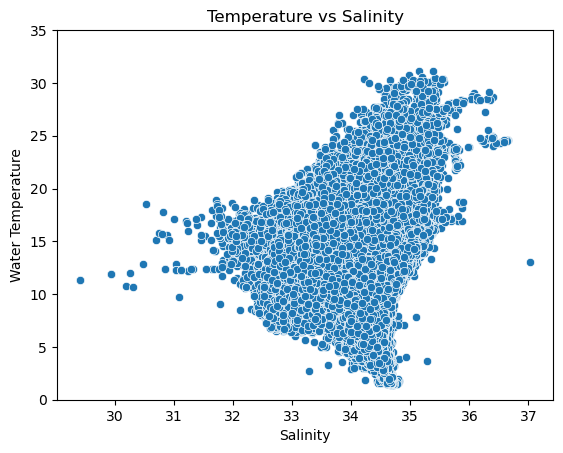

In [121]:
fig, ax = plt.subplots()
sns.scatterplot(data=merged_df, x='Salnty', y='T_degC', ax=ax)
ax.set_ylim(0, 35)
plt.xlabel('Salinity')
plt.ylabel('Water Temperature')
plt.title('Temperature vs Salinity')
plt.show()

We can observe a negative correlation between salinity and temperature. Thus, we can infer that salinity increases as depth increases and temperature decreases.

Now let's look at the amount of oxygen in the water and its temperature.

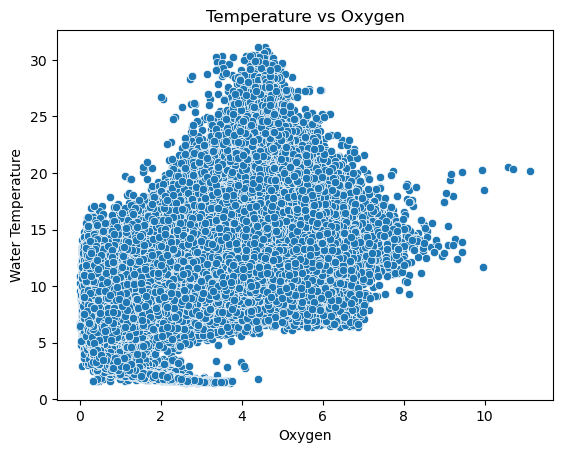

In [122]:
sns.scatterplot(data=merged_df, x='O2ml_L', y='T_degC')
plt.title('Temperature vs Oxygen')
plt.xlabel('Oxygen')
plt.ylabel('Water Temperature')
plt.show()

We can see a positive correlation between the water's oxygen content and its temperature. This observation aligns with the expectation that more oxygen is typically found at shallower depths, where the temperature tends to be higher. 

This relationship becomes even more evident when the points are color-coded by depth. Notably, as 125 meters represents the 50th percentile, it is evident that points associated with greater depths are scattered in the lower portion of the graph.

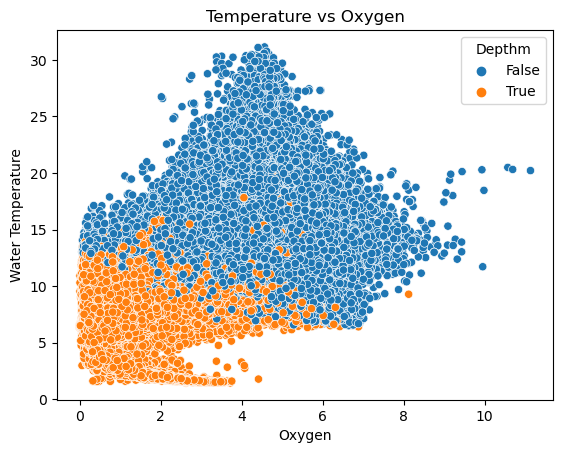

In [123]:
sns.scatterplot(data=merged_df, x='O2ml_L', y='T_degC', hue=x_train.Depthm>125)
plt.title('Temperature vs Oxygen')
plt.xlabel('Oxygen')
plt.ylabel('Water Temperature')
plt.show()

Let's examine whether there is any noticable trend in the temperature levels over the years of observation.

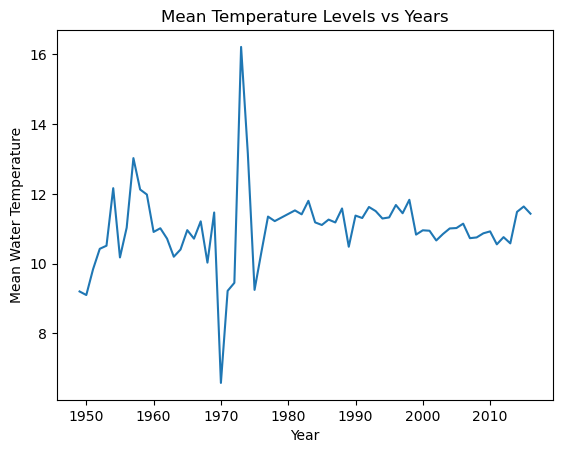

In [124]:
mean_temp_per_year = merged_df.groupby('Year')['T_degC'].mean().reset_index() # Average temperatures across the years.

sns.lineplot(data=mean_temp_per_year, x=mean_temp_per_year.Year.astype(int), y='T_degC')
plt.title('Mean Temperature Levels vs Years')
plt.xlabel('Year')
plt.ylabel('Mean Water Temperature')
plt.show()

There is a small upward trend in this graph but it is not that noticable, so we can conclude that temporal component is not that important fot this data.

Let's examine how the temperature is distributed among months and seasons.

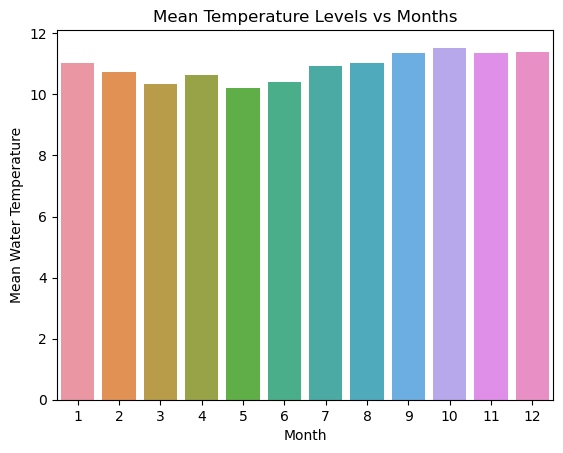

In [125]:
mean_temp_per_month = merged_df.groupby('Month')['T_degC'].mean().reset_index()

sns.barplot(data=mean_temp_per_month, x=mean_temp_per_month.Month.astype(int), y='T_degC')
plt.title('Mean Temperature Levels vs Months')
plt.xlabel('Month')
plt.ylabel('Mean Water Temperature')
plt.show()

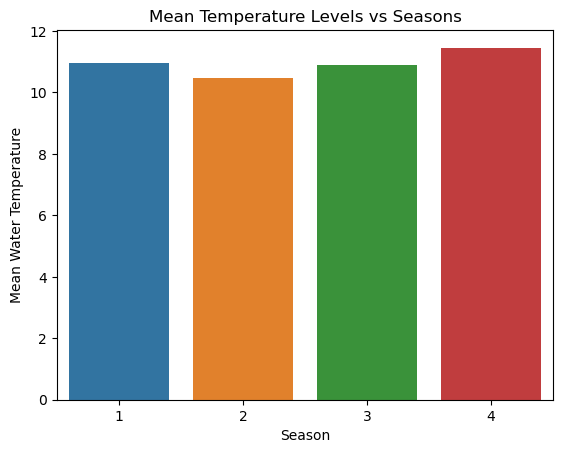

In [126]:
mean_temp_per_season = merged_df.groupby('Season')['T_degC'].mean().reset_index() # Average temperatures across the seasons.

sns.barplot(data=mean_temp_per_season, x=mean_temp_per_season.Season.astype(int), y='T_degC')
plt.title('Mean Temperature Levels vs Seasons')
plt.xlabel('Season')
plt.ylabel('Mean Water Temperature')
plt.show()

It appears that ocean water temperature is not highly dependent on seasonality either.

In summary, we have identified the following significant predictors for the task of predicting water temperature:
- Depth at which the sample was taken
- Salinity of the sample
- Oxygen concentration in the sample
- Latitude and longitude at which the sample was taken

These features exhibit meaningful relationships with the target variable.

### Target Distribution

Next, we will dive into the visualization of target distribution.

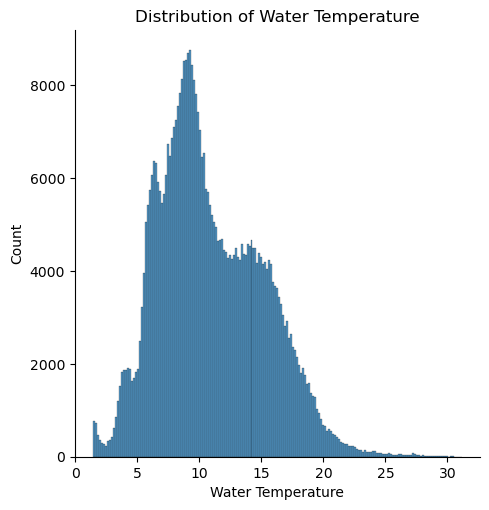

In [127]:
sns.displot(y_train)
plt.title('Distribution of Water Temperature')
plt.xlabel('Water Temperature')
plt.show()

The target variable exhibits a somewhat bimodal distribution with a noticeable rightward tail. Consequently, we may need to log-transform the target variable to enhance the modeling process.

Let's investigate whether the presence of a second peak in the temperature distribution is related to seasonality.

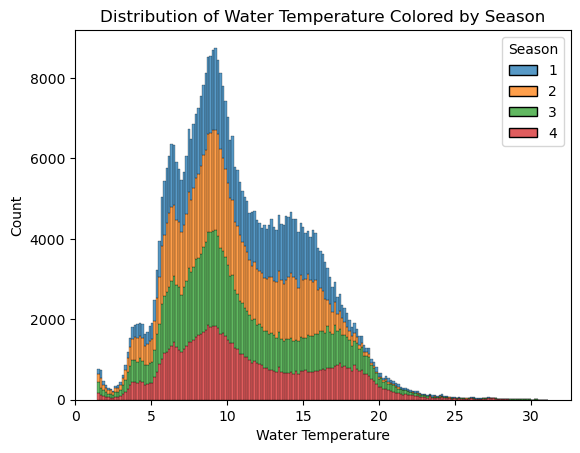

In [128]:
sns.histplot(data=merged_df, x='T_degC', hue='Season', multiple='stack')
plt.title('Distribution of Water Temperature Colored by Season')
plt.xlabel('Water Temperature')
plt.show()

From the stacked plot, it is evident that the temperature distributions across seasons are relatively consistent, indicating that seasonality does not account for the second peak observed on the graph. However, we can infer that the majority of samples were collected during the winter season.

Next, let's explore the possibility that depth might be a contributing factor to the second peak.

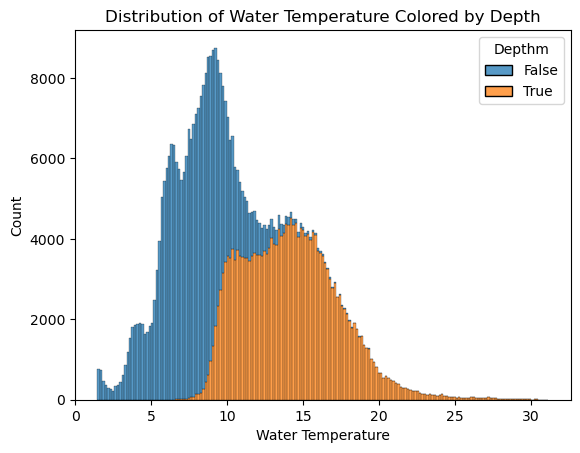

In [129]:
sns.histplot(data=merged_df, x='T_degC', hue=merged_df.Depthm<125, multiple='stack') # Color the plot by the 50th percentile, i.e. 125 meters deep. 
plt.title('Distribution of Water Temperature Colored by Depth')
plt.xlabel('Water Temperature')
plt.show()

Based on this plot we can conclude that distribution of temperature is indeed influenced by the depth at which the samples were taken.

### Features Distribution

Additionally, let's explore the distributions of features and their relationships.

In [ ]:
sns.pairplot(x_train, diag_kind='kde')
plt.show()

From the plots, we can see a noticeable correlation between oxygen concentration and depth, as well as between salinity and depth. Furthermore, the distributions of features exhibit a considerable degree of skewness.

Regarding the spatial coordinates, the distributions indicate that certain stations are used significantly more often compared to the others.

Now let's look at the distributions of categorical data.

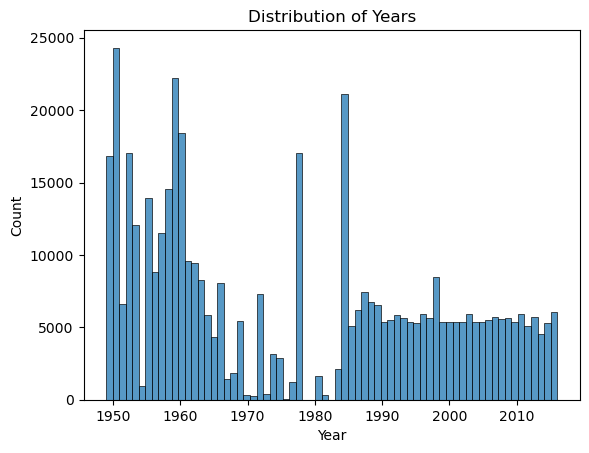

In [131]:
sns.histplot(x=x_train['Year'].astype(int))
plt.title('Distribution of Years')
plt.xlabel('Year')
plt.show()

On this plot we can see that the distribution of samples across years is not uniform - some years are overrepresented and some years are totally missing.

Now let's examine the distributions of seasons and months.

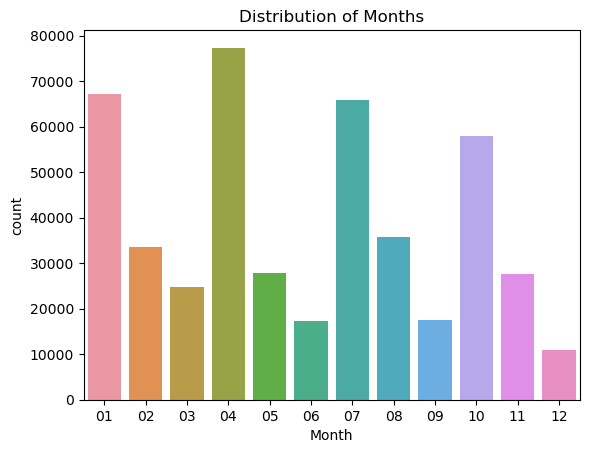

In [132]:
sns.countplot(x=x_train['Month'])
plt.title('Distribution of Months')
plt.xlabel('Month')
plt.show()

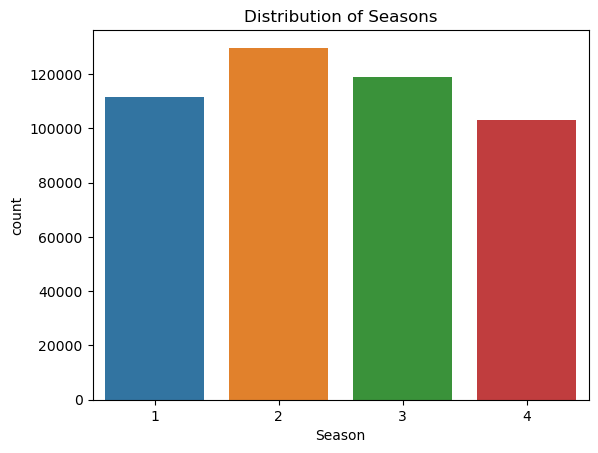

In [133]:
sns.countplot(x=x_train['Season'])
plt.title('Distribution of Seasons')
plt.xlabel('Season')
plt.show()

The count of observations across seasons is relatively uniform; however, concerning months, a recurring pattern of expeditions emerges - the second month of each season exhibits the highest count of expeditions.

<a id="outliers-detection"></a>
## Outliers Detection

Now let's check if we have any outliers in our data.

### Target

First we will examine the target.

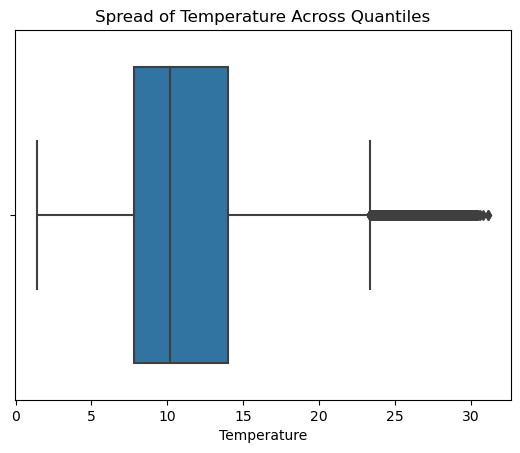

In [134]:
sns.boxplot(data=merged_df, x='T_degC')
plt.title('Spread of Temperature Across Quantiles')
plt.xlabel('Temperature')
plt.show()

We can see numerous data points with temperatures approximately exceeding 24 degrees Celsius, situated beyond 1.5 times the interquartile range from the upper boundary of the third quartile. We need to investigate these points further to determine whether they indicate any form of anomaly.

In [135]:
merged_df.loc[merged_df.T_degC > 24].shape

(1611, 9)

There are 1611 points with temperature higher than 24 degrees Celcius which is too many to be considered outliers.

In [136]:
merged_df.loc[(merged_df.T_degC > 24) & (merged_df.Season == '3')].shape # Check if those points were recorded in summer.

(465, 9)

In [137]:
merged_df.loc[(merged_df.T_degC > 24) & (merged_df.Season == '4')].shape # Check if those points were recorded in autumn.

(834, 9)

In [138]:
merged_df.loc[(merged_df.T_degC > 24) & (merged_df.Season == '2')].shape # Check if those points were recorded in spring.

(47, 9)

In [139]:
merged_df.loc[(merged_df.T_degC > 24) & (merged_df.Season == '1')].shape # Check if those points were recorded in winter.

(265, 9)

Most of these measurements were recorded during the summer and autumn seasons, with fewer data points collected in winter and spring. Considering the geographic location of CalCOFI stations in Southern California, this distribution appears to be reasonable.

Let's now see at which depth these samples were collected.

In [140]:
merged_df.loc[(merged_df.T_degC > 24) & (merged_df.Depthm < 81)].shape

(1611, 9)

All of the points are located at depths less than 81 meters.

Now let's examine if these points come from a specific time interval.

In [141]:
merged_df.loc[(merged_df.T_degC > 24) & (merged_df.Depthm < 81)].groupby('Year').count()

,Depthm,Salnty,O2ml_L,Month,Season,Longitude,Latitude,T_degC
Year,,,,,,,,
1949,2,2,2,2,2,2,2,2
1950,47,47,47,47,47,47,47,47
1951,85,85,85,85,85,85,85,85
1952,11,11,11,11,11,11,11,11
1953,2,2,2,2,2,2,2,2
1954,0,0,0,0,0,0,0,0
1955,41,41,41,41,41,41,41,41
1956,168,168,168,168,168,168,168,168
1957,318,318,318,318,318,318,318,318


All these data points were gathered within the timeframe from 1949 to 1983. Moreover, certain years exhibit only a few observations with exceptionally high temperatures.

Considering that the count of samples displaying unusually high temperatures is relatively small in comparison to the total number of samples, and these measurements are, at most, 40 years old, we may assume that there could be some anomalies in the data collection process.

At this stage, we will refrain from making any adjustments to these points, as we lack a clear understanding of their origin.

### Features

Now let's examine possible outliers in features. 

Let's start with salinity.

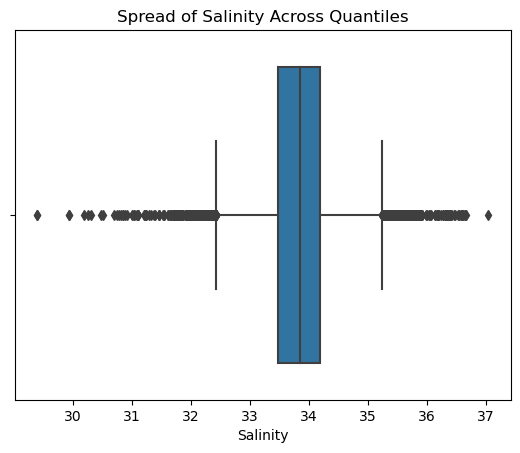

In [142]:
sns.boxplot(data=merged_df, x='Salnty')
plt.title('Spread of Salinity Across Quantiles')
plt.xlabel('Salinity')
plt.show()

Here, it is evident that certain points look like outliers: those situated to the left of 30 and those to the right of 37.

Let's conduct a more detailed examination of these points.

In [143]:
x_train[x_train.Salnty < 30]

,Depthm,Salnty,O2ml_L,Month,Season,Year,Longitude,Latitude
558816,0,29.934,6.88,01,1,1984,-122.880849,37.947435
457067,1,29.402,6.65,05,2,1972,-124.833340,43.943587
558817,1,29.934,6.88,01,1,1984,-122.880849,37.947435
457066,0,29.402,6.65,05,2,1972,-124.833340,43.943587


In [144]:
x_train[x_train.Salnty > 37]

,Depthm,Salnty,O2ml_L,Month,Season,Year,Longitude,Latitude
564387,10,37.034,6.22,02,1,1984,-122.624272,36.914743


Let's see if these salinity levels are typical for the given depths.

In [145]:
merged_df.loc[merged_df['Depthm'] <= 1, 'Salnty'].mean()

33.48866135562967

In [146]:
merged_df.loc[merged_df['Depthm'] == 10, 'Salnty'].mean()

33.50079701057445

The mean salinity level for the depths between 0 and 1 meters is 33.48, and for 10 meters it is 33.5.

Consequently, the observations with salinity levels lower than 30 and higher that 37 seem to be anomalous indeed. Thus, we will delete them from the dataset.

In [147]:
indeces_to_drop = x_train[(x_train.Salnty < 30) | (x_train.Salnty > 37)].index

x_train.drop(indeces_to_drop, inplace=True)
y_train.drop(indeces_to_drop, inplace=True)

Next, we will assess outliers in the depth parameter.

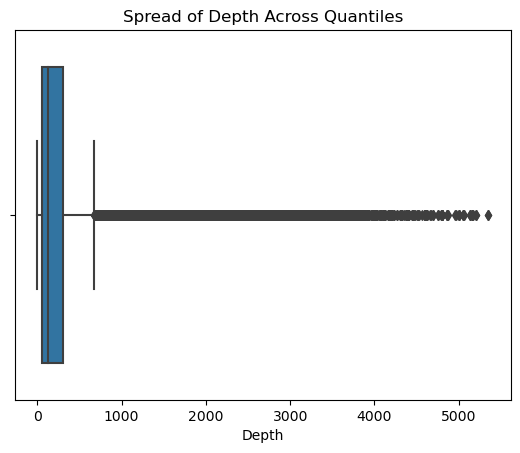

In [148]:
sns.boxplot(data=merged_df, x='Depthm')
plt.title('Spread of Depth Across Quantiles')
plt.xlabel('Depth')
plt.show()

This plot reveals the longer end of the depth distribution, but it doesn't seem like this column has any clear outliers.

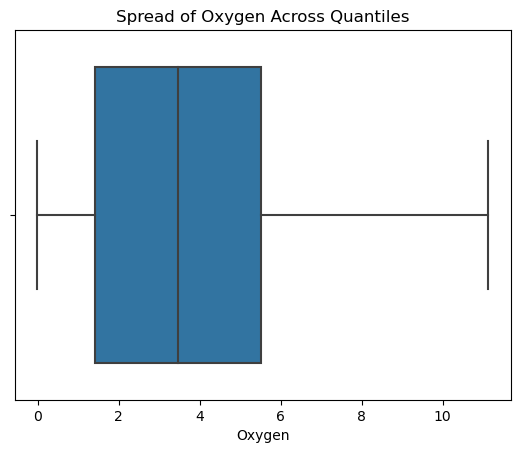

In [149]:
sns.boxplot(data=merged_df, x='O2ml_L')
plt.title('Spread of Oxygen Across Quantiles')
plt.xlabel('Oxygen')
plt.show()

Similarly, oxygen concentration doesn't exhibit any outliers.

<a id="feature-selection"></a>
## Feature Selection

Next, we will perform feature selection using the mutual information score, as it captures non-linear relationships between the target and features, in contrast to a simple correlation analysis.

And then we will assess the collinearity between features.

### Target vs Features 

To better understand the most influential features for predicting water temperature, let's analyze the mutual information scores between the target and the features.

In [150]:
def compute_mi_scores(X, y):
    X = X.copy()
    for col in X.select_dtypes(['object', 'category']):
        X[col], _ = X[col].factorize()
    
    mi_scores = mutual_info_regression(X, y, random_state=1)
    mi_scores = pd.Series(mi_scores, name='Mutual_info', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title('Mutual Info Scores')

In [151]:
mi_scores = compute_mi_scores(x_train, y_train)

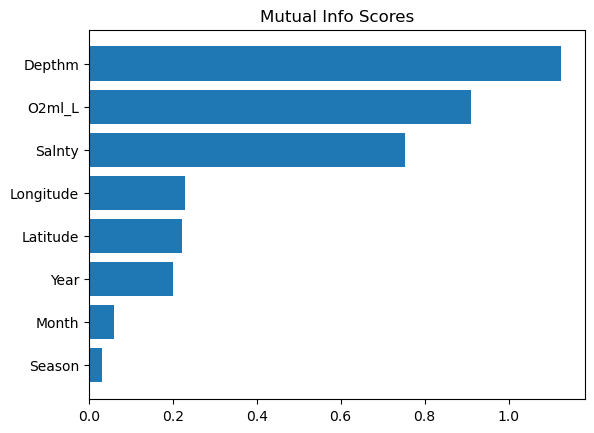

In [152]:
plot_mi_scores(mi_scores)

From the results, it's clear that depth has the most impact on predicting water temperature. Oxygen concentration and salinity come next. However, season and month don't contribute much to prediction, so we won't include them as predictors.

### Features Collinearity

To gain insight into feature correlations, let's construct a correlation matrix.

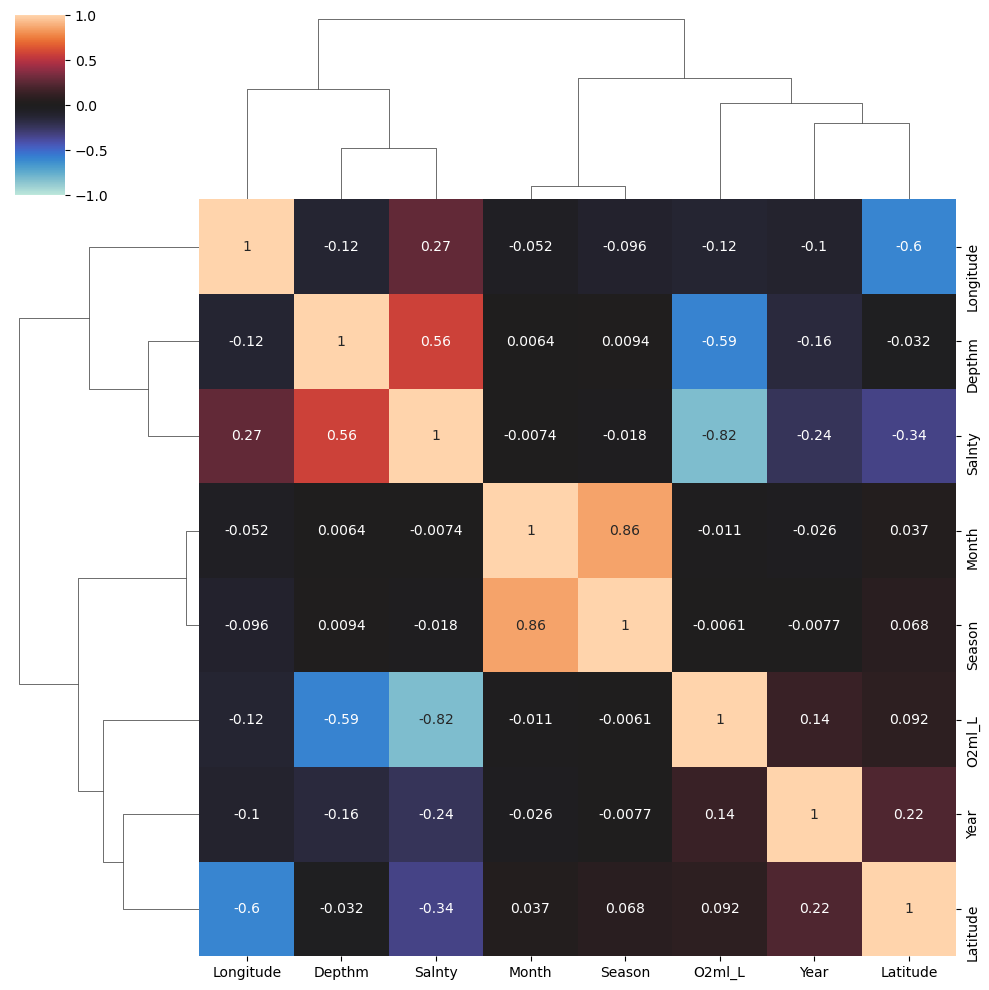

In [153]:
sns.clustermap(x_train.corr('pearson'),
            vmin=-1.0,
            vmax=1.0,
            cmap="icefire",
            method="complete",
            annot=True)

Given the noticable correlation between season and month, and considering that season has a lower mutual information score, we will opt not to include season as a predictor in our model.

<a id="feature-preprocessing"></a>
## Feature Preporcessing and Feature Engineering

To prepare the data for modeling, we will establish a feature preprocessing pipeline. This pipeline will include techniques such as rescaling and applying log transformations to address skewed features. 

Additionally, we'll introduce two new features that characterize the average salinity and oxygen levels corresponding to the given depth.

In [154]:
# Check the skewness of distributions.
print(f"Target skewness: {y_train.skew()}")
print(f"Salinity skewness: {x_train['Salnty'].skew()}")
print(f"Oxygen skewness: {x_train['O2ml_L'].skew()}")
print(f"Salinity skewness: {x_train['Depthm'].skew()}")

Target skewness: 0.4936231679824036
Salinity skewness: 0.0025835176594706743
Oxygen skewness: -0.1341439770528735
Salinity skewness: 4.986737666908478


Salinity has significant skewness, so we will apply a log transformation to adress it.

Moving forward, we will establish a column transformer that will function as our preprocessing pipeline.

In [155]:
log_transformer = FunctionTransformer(np.log1p, validate=True)

data_transformer = ColumnTransformer(
    transformers=[
        ('log_transform', log_transformer, ['Salnty'])
    ],
    remainder=RobustScaler()
)

Now let's create functions to prepare the data: derive temporal features and coordinates, engineer new features, and convert data types.

In [156]:
def derive_features(df):
    df['Year'] = df['Depth_ID'].str.slice(0,2) + df['Depth_ID'].str.slice(3,5)
    df['Month'] = df['Depth_ID'].str.slice(5,7)
    df[['Line', 'Station']] = df['Sta_ID'].str.split(expand=True)
    df['Line'] = df['Line'].astype(float) 
    df['Station'] = df['Station'].astype(float) 
    
    df[['Longitude', 'Latitude']] = df.apply(lambda row: pd.Series(stationtolatlon(row['Line'], row['Station'])), axis=1)
    return df


def engineer_features(df, avg_o2_per_depth=None, avg_sal_per_depth=None, training=True):
    original_index = df.index 
    
    if training:
        avg_o2_per_depth = df.groupby('Depthm')['O2ml_L'].mean().reset_index()
        avg_o2_per_depth.columns = ['Depthm', 'Avg_O2']
        df = df.merge(avg_o2_per_depth, on='Depthm', how='left')
        
        avg_sal_per_depth = df.groupby('Depthm')['Salnty'].mean().reset_index()
        avg_sal_per_depth.columns = ['Depthm', 'Avg_Salinity']
        df = df.merge(avg_sal_per_depth, on='Depthm', how='left')
        df.index = original_index
        
        return df, avg_o2_per_depth, avg_sal_per_depth
    else:
        df = df.merge(avg_o2_per_depth, on='Depthm', how='left', suffixes=('', ''))
        df = df.merge(avg_sal_per_depth, on='Depthm', how='left', suffixes=('', ''))
    
    df.index = original_index
    return df


def prepare_data(df):
    df['Year'] = df['Year'].astype(int)
    return df

In [157]:
x_train, avg_o2_per_depth, avg_sal_per_depth = engineer_features(x_train)
x_train = prepare_data(x_train)

<a id="model-choosing"></a>
## Choosing a Model

Let's transition to the modeling phase. We'll kick off by establishing a baseline model, curating a list of predictors, and developing a function to assess the performance of models.

We will leverage from log transforming the target as it is not normally distributed.

In [158]:
baseline_pipeline = make_pipeline(
    data_transformer,
    TransformedTargetRegressor(regressor=LinearRegression(),
                               func=np.log,
                               inverse_func=np.exp)
)


In [159]:
predictors = ['Depthm', 'Salnty', 'O2ml_L', 'Latitude', 'Longitude', 'Avg_O2', 'Avg_Salinity', 'Year', 'Month']

In [160]:
def evaluate(model, X, y):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=5,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"], error_score='raise'
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

Let's see how well the baseline model performs.

In [161]:
evaluate(baseline_pipeline, x_train[predictors], y_train)

Mean Absolute Error:     1.005 +/- 0.002
Root Mean Squared Error: 1.409 +/- 0.002


This represents our baseline score, which we aim to surpass.

To begin, let's explore enhancing the model by introducing polynomial features. Here we added a non-negativity constraint on the coefficients as this model output negative values in the test time.

In [162]:
polynomial_pipeline = make_pipeline(
    data_transformer,
    PolynomialFeatures(),
    TransformedTargetRegressor(regressor=LinearRegression(positive=True),
                               func=np.log,
                               inverse_func=np.exp) 
)

evaluate(polynomial_pipeline, x_train[predictors], y_train)

Mean Absolute Error:     0.987 +/- 0.003
Root Mean Squared Error: 1.549 +/- 0.019


The results got a bit better.

Now let's try using the piecewise polynomials (i. e. b-spline regression).

In [172]:
splines_pipeline = make_pipeline(
    data_transformer,
    SplineTransformer(n_knots=23, degree=3),
    TransformedTargetRegressor(regressor=LinearRegression(),
                               func=np.log,
                               inverse_func=np.exp)
)

evaluate(splines_pipeline, x_train[predictors], y_train)

Mean Absolute Error:     0.737 +/- 0.001
Root Mean Squared Error: 1.114 +/- 0.003


The results of the b-spline regression are even better than the polynomial one. So we will go with the b-spline regression as it yields the best result.

<a id="model-evaluating"></a>
## Fitting and Evaluating the Model

Next, we will proceed to fitting and evaluating the chosen model on our testing data.

In [173]:
splines_pipeline = make_pipeline(
    data_transformer,
    SplineTransformer(n_knots=23, degree=3),
    TransformedTargetRegressor(regressor=LinearRegression(),
                               func=np.log,
                               inverse_func=np.exp)
)

splines_pipeline.fit(x_train[predictors], y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=RobustScaler(),
                                   transformers=[('log_transform',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True),
                                                  ['Salnty'])])),
                ('splinetransformer', SplineTransformer(n_knots=23)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=LinearRegression()))])

In [174]:
# Prepare the testing data.
x_test = derive_features(x_test)
x_test = engineer_features(x_test, avg_o2_per_depth, avg_sal_per_depth, training=False)
x_test = prepare_data(x_test)

When we introduced new features representing mean salinity and oxygen levels at various depths, we created some NaN values in the test data. This is due to the potential differences in depth values between the test and training data. To address this, we will use linear interpolation to replace the missing values with interpolated values based on the training data.

In [175]:
def impute_mean_by_depth(df, col, ref_df):
    missing_mask = df[col].isnull()
    
    if missing_mask.any():
        interpolation_func = np.interp(df.loc[missing_mask, 'Depthm'], ref_df['Depthm'], ref_df[col])
        df.loc[missing_mask, col] = interpolation_func
    return df

In [176]:
x_test = impute_mean_by_depth(x_test, 'Avg_O2', avg_o2_per_depth)
x_test = impute_mean_by_depth(x_test, 'Avg_Salinity', avg_sal_per_depth)

In [177]:
test_predictions = splines_pipeline.predict(x_test[predictors])
predictions_mae = mean_absolute_error(y_test, test_predictions)
predictions_rmse = mean_squared_error(y_test, test_predictions, squared=False)

print(
    f"Mean Absolute Error:     {predictions_mae:.3f}\n"
    f"Root Mean Squared Error: {predictions_rmse:.3f}"
    )

Mean Absolute Error:     0.737
Root Mean Squared Error: 1.117


The result is not far from the training set metrics, so we have not overfitted.

Let's now plot the residuals to see if there are any patterns.

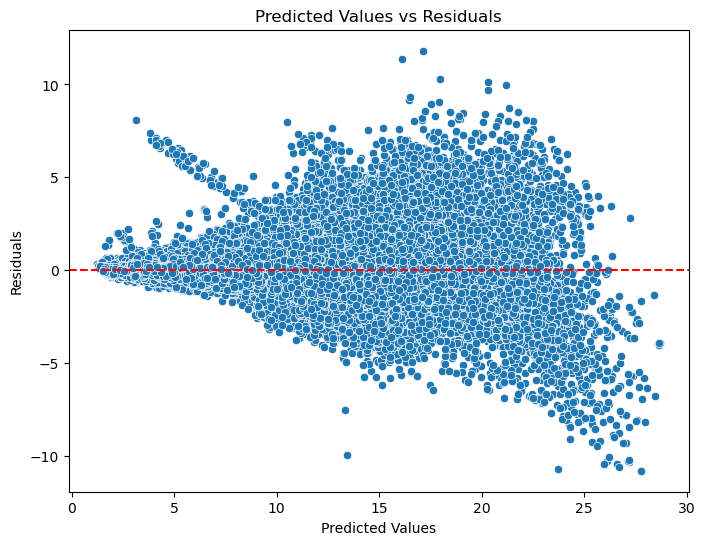

In [178]:
residuals = y_test - test_predictions

plt.figure(figsize=(8, 6))
sns.scatterplot(x=test_predictions, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Predicted Values vs Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

Analyzing the plot, we observe that the model tends to underestimate real temperature values up to approximately 10 degrees. For temperature values higher than 10 and up to ~24 degrees the residuals are distributed more or less randomly. On the other hand, when the model predicts temperatures exceeding 25 degrees, it tends to overshoot the actual temperature.

If we plot true values against residuals we can derive some more intuitions. 

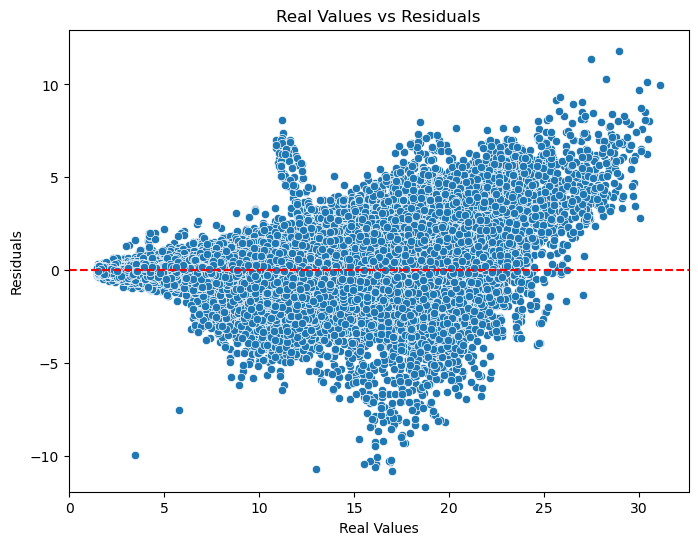

In [179]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Real Values vs Residuals')
plt.xlabel('Real Values')
plt.ylabel('Residuals')
plt.show()

We can observe that predicting temperatures up to around 7 degrees appears to be relatively simpler for the model. However, in the range of 7 to 20 degrees, our predictions are more likely to overshoot. Beyond approximately 20 degrees, our model tends to undershoot more frequently. Furthermore, as noted, errors notably increase when predicting temperatures exceeding 25 degrees.

In summary, the analysis of residuals reveals non-random distribution patterns, potentially indicating the presence of heteroscedasticity in the dependent variable. Notably, there are indentifiable trends such as underestimation in certain temperature ranges, overshooting in others, and increased error for higher temperature predictions. These observed patterns indicate that our model might benefit from implementing more measures to address heteroscedasticity.

<a id="conclusion"></a>
## Conclusion

Our goal of predicting ocean water temperature using linear regression involved a comprehensive sequence of activities including data preprocessing, feature engineering, and model assessment. This analysis uncovered intricate relationships between temperature and various predictors, including factors like depth, salinity, oxygen concentration, and spatiotemporal influences.

While our linear regression models showed a reasonable predictive performance, they also illuminated some temperature prediction challenges (i. e. non-constant variance in the dependent variable). Through residual analysis, we identified systematic patterns, in particular, underestimations, overshooting tendencies, and distinctive prediction challenges across temperature ranges. 

Looking ahead, there is a potential to engineer additional features, refine the list of predictors, explore alternative models, potentially refine the dataset by removing older data points, and identifying anomalies better.